In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.stats import norm
import pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display, clear_output
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
class Visualizer(object):
    def __init__(self,
                 figsize,
                 loss_xlim=None,
                 loss_ylim=None,
                 plot_interval=1):
        self.loss_xlim = loss_xlim
        self.loss_ylim = loss_ylim
        self.plot_interval = plot_interval
        sns.set()
        self.fig = plt.figure(figsize=figsize)
        self.rows, self.cols = 4, 4

    def plot_subgrid(self, gs, images, title):
        outer_ax = plt.subplot(gs)
        outer_ax.set_title(title)
        outer_ax.set_xticks([])
        outer_ax.set_yticks([])

        inner_grid = gridspec.GridSpecFromSubplotSpec(
            self.rows, self.cols, subplot_spec=gs, wspace=.1, hspace=.1)

        for i, image in enumerate(images[:(self.rows * self.cols)]):
            ax = plt.Subplot(self.fig, inner_grid[i])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            ax.imshow(image.data.cpu().numpy().reshape(28, 28), cmap='Greys_r')
            self.fig.add_subplot(ax)

    def plot(self, x, x_recon, x_gen, z, loss_dict):
        # Create gridspec here instead of __init__
        gs = gridspec.GridSpec(2, 4, wspace=.2, hspace=.2,
                               height_ratios=(2, 1.5))

        self.plot_subgrid(gs[0], x, 'data')
        self.plot_subgrid(gs[1], x_recon, 'reconstructed data')
        self.plot_subgrid(gs[2], x_gen, 'generated samples')

        ax_z = plt.subplot(gs[3])
        # Plot the first two dimensions
        ax_z.scatter(z[:, 0], z[:, 1], 1)
        ax_z.set_title('latent samples')
        ax_z.set_aspect('equal', adjustable='datalim')

        ax_trace = plt.subplot(gs[1, :])
        ax_trace.set_ylabel('loss')
        ax_trace.set_xlabel('epochs')
        if self.loss_xlim is not None:
            ax_trace.set_xlim(self.loss_xlim)
        if self.loss_ylim is not None:
            ax_trace.set_ylim(self.loss_ylim)
        for label, loss in loss_dict.items():
            plot_iter = np.arange(len(loss)) * self.plot_interval
            ax_trace.plot(plot_iter, loss, '-', label=label)
        if len(loss_dict) > 1:
            ax_trace.legend(ncol=len(loss_dict), loc='upper center')
        self.draw()

    def draw(self):
        clear_output(wait=True)
        display(self.fig)

In [3]:
cuda = torch.cuda.is_available()

if cuda:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
    
activation = F.softplus


class Decoder(nn.Module):
    def __init__(self, input_features, latent_features, 
                 hidden1=500, hidden2=500):
        super(Decoder, self).__init__()
        self.fc0 = nn.Linear(latent_features, hidden1)
        self.fc1 = nn.Linear(hidden1, hidden2)
        self.fc2 = nn.Linear(hidden2, input_features)

    def forward(self, z):
        y = activation(self.fc0(z))
        y = activation(self.fc1(y))
        logit = self.fc2(y)
        x_recon = torch.sigmoid(logit)
        return logit, x_recon


class Encoder(nn.Module):
    def __init__(self, input_features, latent_features,
                 hidden1=500, hidden2=500):
        super(Encoder, self).__init__()
        self.input_features = input_features
        self.latent_features = latent_features
        self.fc0 = nn.Linear(input_features, hidden1)
        self.fc1 = nn.Linear(hidden1, hidden2)
        self.fc_mu = nn.Linear(hidden2, latent_features)
        self.fc_logvar = nn.Linear(hidden2, latent_features)

    def forward(self, x):
        x = activation(self.fc0(x))
        x = activation(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        std = (logvar * .5).exp()
        eps = Variable(std.data.new(std.size()).normal_())
        # Reparameterization
        z0 = mu + std * eps
        return z0, mu, logvar


class VariationalAutoencoderLoss(nn.Module):
    def __init__(self, encoder, decoder):
        super(VariationalAutoencoderLoss, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._log_2pi = math.log(2 * math.pi)

    def forward(self, x):
        samples = x.size(0)
        z, mu, logvar = self.encoder(x)
        x_logit, x_recon = self.decoder(z)
        # Bernoulli noise
        recon_loss = F.binary_cross_entropy_with_logits(
            x_logit, x, size_average=False) / samples
        # Gaussian noise
        #recon_loss = F.mse_loss(x_logit, x, size_average=False) / samples

        kl_loss = -(1 + logvar - mu**2 - logvar.exp()).sum() * .5 / samples
        loss = recon_loss + kl_loss
        # For debugging
        self.z = z
        self.x_recon = x_recon
        self.recon_loss = recon_loss
        self.kl_loss = kl_loss
        return loss


def train_vae(data, decoder, encoder, epochs=100, batch_size=64, seed=3):
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    data_loader = DataLoader(data, shuffle=True, batch_size=batch_size, **kwargs)
    # Evaluate the training progress using 2000 examples from the training data
    test_loader = DataLoader(data, batch_size=2000, **kwargs)

    vae_loss = VariationalAutoencoderLoss(encoder, decoder)
    if cuda:
        vae_loss = vae_loss.cuda()

    optimizer = optim.Adam(vae_loss.parameters())

    loss_history = []
    recon_history = []
    kl_history = []
    plot_interval = 1

    history = {
        'loss': loss_history,
        'reconstruct': recon_history,
        'KL': kl_history,
    }

    vis = Visualizer(figsize=(16, 7),
                     loss_xlim=(0, epochs),
                     #loss_ylim=(0, 150),
                     plot_interval=plot_interval)

    for epoch in range(epochs):
        for batch_idx, (batch_x, _) in enumerate(data_loader):
            batch_x = Variable(batch_x.view(-1, 784).type(dtype))
            optimizer.zero_grad()
            loss = vae_loss(batch_x)
            loss.backward()
            optimizer.step()

        if epoch % plot_interval == 0:
            batch_x, _ = iter(test_loader).next()
            batch_x = Variable(batch_x.view(-1, 784).type(dtype), volatile=True)

            loss = vae_loss(batch_x)
            loss_history.append(loss.item())
            z = vae_loss.z.data.cpu().numpy()
            x_recon = vae_loss.x_recon
            _, x_gen = decoder(Variable(torch.randn(z.shape).type(dtype)))

            recon_history.append(vae_loss.recon_loss.item())
            kl_history.append(vae_loss.kl_loss.item())

            vis.plot(batch_x, x_recon, x_gen, z, history)
            
    return vae_loss

In [4]:
data = datasets.MNIST('data', train=True, download=True,
                      transform=transforms.ToTensor())

## VAE with 2-dimensional latent space

In [5]:
input_features, latent_features = 784, 2
if(os.path.exists("./2d_mnist_vae_decoder.pt") and os.path.exists("./2d_mnist_vae_encoder.pt")):
    decoder = Decoder(input_features, latent_features)
    decoder.load_state_dict(torch.load("./2d_mnist_vae_decoder.pt"))
    decoder.eval()

    encoder = Encoder(input_features, latent_features)
    encoder.load_state_dict(torch.load("./2d_mnist_vae_encoder.pt"))
    encoder.eval()

    vae_2d = VariationalAutoencoderLoss(encoder,decoder)
    print("Loaded 2D MNIST VAE")
else:
    decoder = Decoder(input_features, latent_features)
    encoder = Encoder(input_features, latent_features)
    vae_2d = train_vae(data, decoder, encoder)
    torch.save(decoder.state_dict(), "./2d_mnist_vae_decoder.pt")
    torch.save(encoder.state_dict(), "./2d_mnist_vae_encoder.pt")

Loaded 2D MNIST VAE


## Visualization of latent manifold with labels

/Applications/anaconda3/envs/689/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


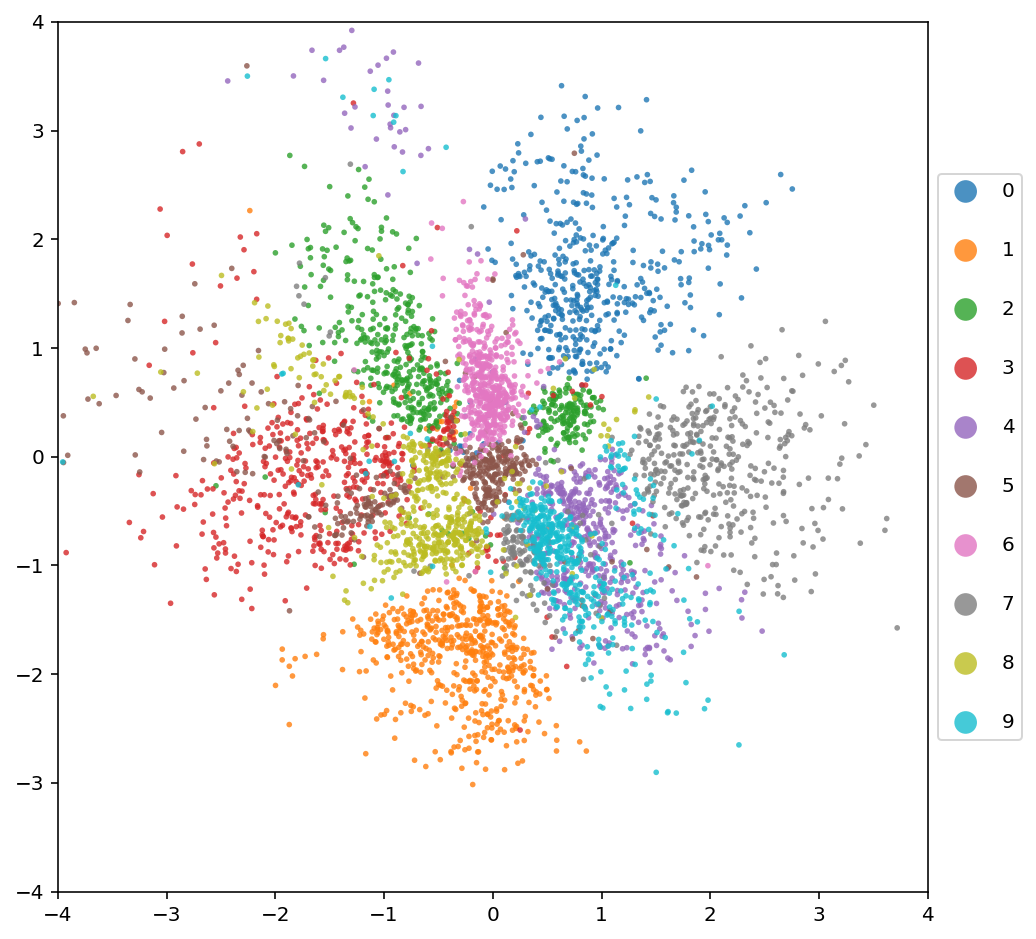

In [6]:
def plot_labels(model, z_index=(0, 1)):    
    x, y = iter(DataLoader(data, batch_size=5000, shuffle=True)).next()
    model(Variable(x.view(-1, input_features).type(dtype)))
    z = model.z.data.cpu().numpy()
    y = y.numpy()
    fig, ax = plt.subplots(figsize=(8, 8))
    cm = plt.get_cmap('tab10')
    ax.set_prop_cycle('color', cm(np.linspace(0, 1, 10)))
    for i in range(10):
        z_sub = z[y == i]
        ax.scatter(z_sub[:, z_index[0]], z_sub[:, z_index[1]], s=8, label=str(i), alpha=.8,
                   edgecolors='none')
    ax.set_aspect('equal')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
              markerscale=4, labelspacing=2)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    plt.show()
    
plot_labels(vae_2d)

## Learned manifold

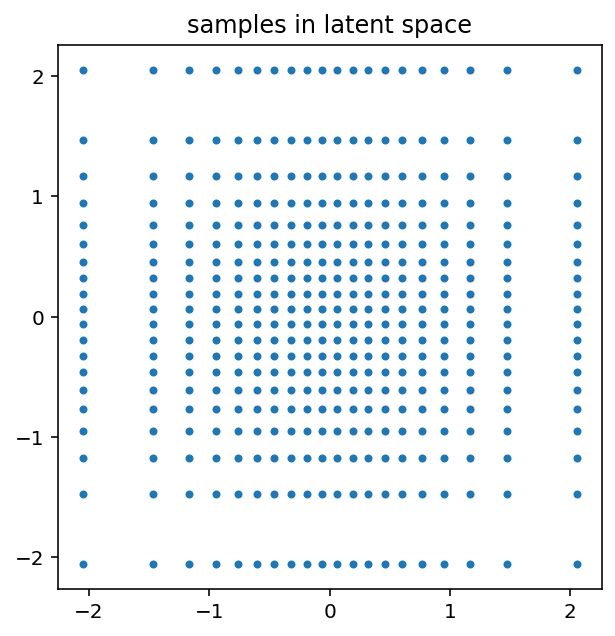

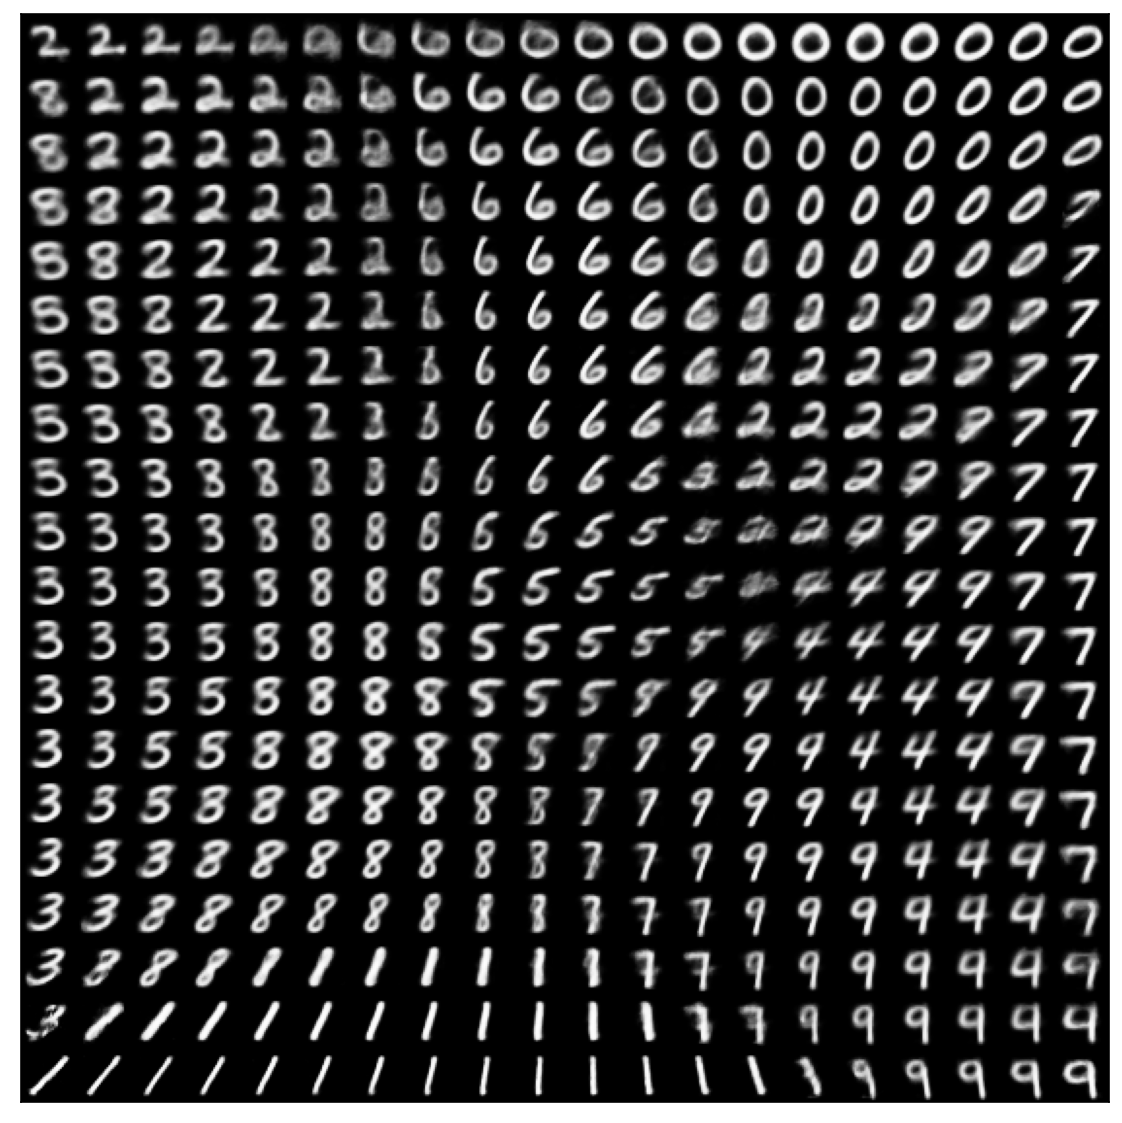

In [7]:
dim_samples = 20
# Evenly-spaced samples between 0 and 1
u = np.linspace(.02, .98, dim_samples)
# Inverse CDF of Gaussian
x = norm.ppf(u)
grid = np.meshgrid(x, x)
z = np.column_stack((grid[0].flatten(), grid[1].flatten()))
_, x_gen = vae_2d.decoder(Variable(torch.FloatTensor(z).type(dtype)))

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(z[:, 0], z[:, 1], '.')
ax.set_title('samples in latent space')
ax.set_aspect('equal')

x_all = np.empty((dim_samples * 28, dim_samples * 28))
for i, x in enumerate(x_gen.data.cpu().numpy()):
    pos1 = (dim_samples - 1 - i // dim_samples) * 28
    pos2 = (i % dim_samples) * 28
    x_all[pos1:(pos1 + 28), pos2:(pos2 + 28)] = x.reshape(28, 28)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')
ax.imshow(x_all, cmap='Greys_r')
fig.add_subplot(ax)
    
plt.show()

## Generation 

In [9]:
def generate(Z,decoder):
    _, x_gen = vae_2d.decoder(Variable(torch.FloatTensor(Z).type(dtype)))
    return(x_gen)

def f(z1,z2):
    plt.grid(False)
    z = np.array([z1,z2])
    x = generate(z,decoder).detach().numpy().reshape((28,28))
    plt.imshow(x,cmap=plt.cm.gray,interpolation=None,vmin=0,vmax=1)
    plt.show()

interact(f,z1=(-4.0,4.0),z2=(-4.0,4.0),
         continuous_update=False);

interactive(children=(FloatSlider(value=0.0, description='z1', max=4.0, min=-4.0), FloatSlider(value=0.0, desc…

## Blurriness of generative model

Optimizing the ELBO is equivalent to minimizing 
$D_{KL}\left(q(\mathbf{x})q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z})p_\theta(\mathbf{x}|\mathbf{z})\right)$
as

$$
\begin{split}
& 
D_{KL}\left(q(\mathbf{x})q_\phi(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z})p_\theta(\mathbf{x}|\mathbf{z})\right) \\
&= 
-\mathbb{E}_{q(\mathbf{x})}\left[
\mathbb{E}_{q_\phi(\mathbf{z}|\mathbf{x})}\left[\log p(\mathbf{z}) + \log p_\theta(\mathbf{x}|\mathbf{z})\right]
- \log q(\mathbf{x})
\right] \\
&=
-\text{ELBO} - \mathcal{H}(q(\mathbf{x}))
\end{split}
$$

where $q(\mathbf{x})$ is the empirical distribution of the data and the entropy $\mathcal{H}(q(\mathbf{x}))$ is a constant independent of $\phi$ and $\theta$.

For $\theta$, the KL divergence is in the "mode covering" direction, that is:

* $p_\theta(\mathbf{x}|\mathbf{z})$ should have non-zero density wherever $q(\mathbf{x}) > 0$.
* Little penalty for $p_\theta(\mathbf{x}|\mathbf{z})$ to put probability mass on values of $\mathbf{x}$ with no support under $q(\mathbf{x})$.

This suggests that the variance of $p_\theta(\mathbf{x}|\mathbf{z})$ will end up larger than that of $q(\mathbf{x})$.

To generate less blurry samples, we can choose a more expressive inference model and/or a more expressive generative model to reduce the KL gap. In the following, we show that by simply using a higher-dimensional latent space, we can get sharper samples and achieve a better ELBO value.

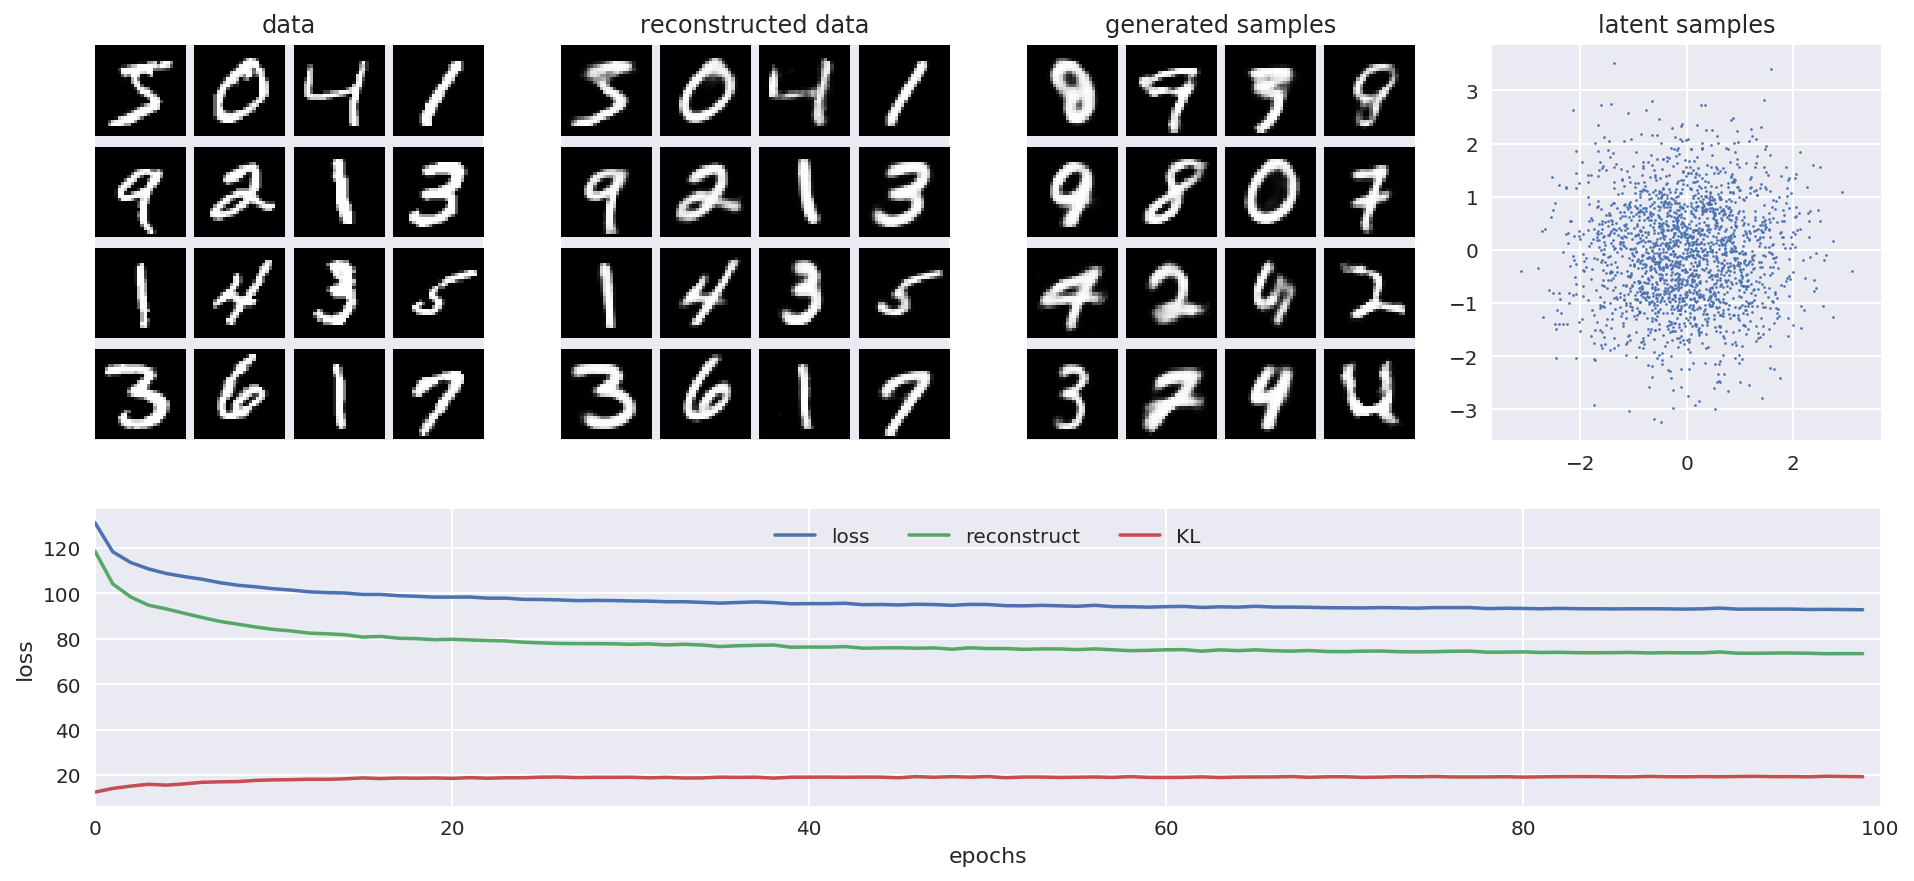

In [9]:
input_features, latent_features = 784, 20
decoder = Decoder(input_features, latent_features)
encoder = Encoder(input_features, latent_features)
vae = train_vae(data, decoder, encoder)

## References

1. [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
2. [Variational Inference and Deep Learning: A New Synthesis](https://www.dropbox.com/s/v6ua3d9yt44vgb3/cover_and_thesis.pdf)